# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from typing import Union
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf


plt.style.use('bmh')

nfl_colors = {
    "ARI": "#97233F",  # Arizona Cardinals
    "ATL": "#A71930",  # Atlanta Falcons
    "BAL": "#241773",  # Baltimore Ravens
    "BUF": "#00338D",  # Buffalo Bills
    "CAR": "#0085CA",  # Carolina Panthers
    "CHI": "#0B162A",  # Chicago Bears
    "CIN": "#FB4F14",  # Cincinnati Bengals
    "CLE": "#311D00",  # Cleveland Browns
    "DAL": "#041E42",  # Dallas Cowboys
    "DEN": "#FB4F14",  # Denver Broncos
    "DET": "#0076B6",  # Detroit Lions
    "GB":  "#203731",  # Green Bay Packers
    "HOU": "#03202F",  # Houston Texans
    "IND": "#002C5F",  # Indianapolis Colts
    "JAX": "#006778",  # Jacksonville Jaguars
    "KC":  "#E31837",  # Kansas City Chiefs
    "LAC": "#0080C6",  # Los Angeles Chargers
    "LAR": "#003594",  # Los Angeles Rams
    "LV":  "#000000",  # Las Vegas Raiders
    "MIA": "#008E97",  # Miami Dolphins
    "MIN": "#4F2683",  # Minnesota Vikings
    "NE":  "#002244",  # New England Patriots
    "NO":  "#D3BC8D",  # New Orleans Saints
    "NYG": "#0B2265",  # New York Giants
    "NYJ": "#125740",  # New York Jets
    "PHI": "#004C54",  # Philadelphia Eagles
    "PIT": "#FFB612",  # Pittsburgh Steelers
    "SEA": "#002244",  # Seattle Seahawks
    "SF":  "#AA0000",  # San Francisco 49ers
    "TB":  "#D50A0A",  # Tampa Bay Buccaneers
    "TEN": "#0C2340",  # Tennessee Titans
    "WAS": "#773141",
    "LA": "blue"# Washington Football Team
}

# Processing functions

In [2]:
def calculate_angle(point1, point2):
  # Calculate differences in x and y coordinates
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    
    # Calculate angle in radians using atan2
    angle_radians = np.arctan2(dy, dx)
    
    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)
    
    
    
    return (angle_degrees -90) *-1


def _distance_from_point(x_distance: Union[float, np.ndarray], 
                        x_point: Union[float, np.ndarray], 
                        y_distance: Union[float, np.ndarray], 
                        y_point: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Calculate the Euclidean distance from a specific point or points to one or more other points.

    Parameters:
    x_distance (Union[float, np.ndarray]): X-coordinate(s) of the point(s) to calculate the distance to.
    x_point (Union[float, np.ndarray]): X-coordinate(s) of the reference point(s).
    y_distance (Union[float, np.ndarray]): Y-coordinate(s) of the point(s) to calculate the distance to.
    y_point (Union[float, np.ndarray]): Y-coordinate(s) of the reference point(s).

    Returns:
    Union[float, np.ndarray]: The Euclidean distance(s) between the pairs of points.
                               Returns a single float if the inputs are floats, or an array of floats if the inputs are arrays.
    """
    return np.sqrt((x_distance - x_point)**2 + (y_distance - y_point)**2)

def convert_height_to_inches(arr: pd.Series)->pd.Series:
    if arr.dtype == 'object':
        height_inches = arr.str[0].astype('int')*12 +arr.str[2].astype('int')
        return height_inches
    return arr

def flatten_and_rename(df,index_cols, value_cols):
    df.columns = index_cols + value_cols 
    return df
def calculate_yac(df:pd.DataFrame)->pd.Series:
    direction_right_bool = df['playDirection'] =='right'
    df['yac'] = df['end_play_event'] - df['pass_outcome_caught']
    df['yac'] = np.where(direction_right_bool,df['yac'],(-1*df['yac']))
    return df

def calculate_distance_down_field(df:pd.DataFrame)->pd.Series:
        direction_right_bool = df['playDirection'] =='right'
        df['yards_down_field'] = df['x'] - df['ball_carrier_x']
        df.loc[~direction_right_bool,'yards_down_field'] = -1* df['yards_down_field']
        return df
        
def calculate_distance_right(df:pd.DataFrame)-> pd.Series:
        direction_right_bool = df['playDirection'] =='right'
        df['yards_right'] = df['y'] - df['ball_carrier_y']
        df.loc[~direction_right_bool,'yards_right'] = -1* df['yards_right']
        return df
    

def calculate_distance_from_sideline(y: pd.Series)->pd.Series:
    return np.where(y > 53.3/2, 53.3-y , y)
    
def _angle_of_approach(theta_1, theta_2):
    # Calculate the difference in angles
    angle_diff = theta_1 - theta_2
    
    # Normalize the angle to be within -180 to 180 degrees
    angle_of_approach = (angle_diff + 180) % 360 - 180
    
    # The angle of approach should be the absolute value as it represents the magnitude
    # of the smallest angle needed to face the ball carrier
    angle_of_approach = abs(angle_of_approach)
    
    return angle_of_approach

def _angle_from_point(x_angle, x_point, y_angle, y_point):
    """
    Calculate the angle from a reference point (x_point, y_point) to a target point (x_angle, y_angle).
    The angle is calculated with 0 degrees being along the positive y-axis, and positive angles
    being clockwise from there.
    
    Parameters:
    x_angle (np.ndarray or pd.Series): x-coordinates of the target points
    x_point (np.ndarray or pd.Series): x-coordinates of the reference points
    y_angle (np.ndarray or pd.Series): y-coordinates of the target points
    y_point (np.ndarray or pd.Series): y-coordinates of the reference points
    
    Returns:
    np.ndarray or pd.Series: The angles from the reference points to the target points in degrees
    """

    x_diff = x_angle - x_point
    y_diff = y_angle - y_point
    angle_radians = np.arctan2( y_diff , x_diff)
    angle_degrees = (np.degrees(angle_radians) -90) * -1
    
    negative_angle_mask = angle_degrees < 0
    angle_degrees[negative_angle_mask] =  angle_degrees[negative_angle_mask] +360
    return angle_degrees

def _angle_of_approach(theta_1, theta_2) -> pd.DataFrame:
    # Calculate the difference in angles
    angle_diff = theta_1 - theta_2
    
    # Normalize the angle to the range [-180, 180)
    angle_of_approach = (angle_diff + 180) % 360 - 180
    
    # Since we want a positive angle representing the magnitude of the approach angle,
    # take the absolute value
    return np.abs(angle_of_approach)



def create_ball_carrier_position_cols(tracking_df, plays_df):
    """
    For all frames returns x, y,s,a,dis for ball carrier on play
    Preprocessing Step for calculate ball carrier diffs
    Creates 1 record per ball carrier
    """
    keep_cols = ['gameId','playId','ballCarrierDisplayName','frameId',
             'x', 'y', 's','a','dis','defensiveTeam','dir']
    rename_cols = ['x', 'y', 's','a','dis','o','a','dir']
    rename_prefix = 'ball_carrier_'
    final_join_cols = ['gameId','playId','frameId']
    return(tracking_df
           .merge(
                 plays_df, 
                 left_on= ['gameId','playId','nflId'], 
                 right_on = ['gameId','playId','ballCarrierId'], 
                 how = 'inner'
              )
           .loc[:, keep_cols]
           .rename({col :rename_prefix + col for col in rename_cols} , axis = 1)
          )

def calculate_ball_carrier_diffs(ball_carrier_pos_df: pd.DataFrame)-> pd.DataFrame:
    return (ball_carrier_pos_df
           .assign(distance_from_ball_carrier = lambda df: _distance_from_point(df['x'],df['ball_carrier_x'],df['y'],df['ball_carrier_y']),
                   
                   angle_from_ball_carrier = lambda df: _angle_from_point(df['ball_carrier_x'],df['x'],df['ball_carrier_y'],df['y']), 
                   angle_of_approach = lambda df: _angle_of_approach(df['angle_from_ball_carrier'] , df['dir']),
                   cos_angle_of_approach = lambda df: cos_in_degrees(df['angle_of_approach']),
                   ball_carrier_distance_from_sideline = lambda df: calculate_distance_from_sideline(df['ball_carrier_y']),
                   player_distance_from_sideline = lambda df: calculate_distance_from_sideline(df['y'])
                  )
            
           .pipe(lambda df: calculate_distance_down_field(df))
           .pipe(lambda df: calculate_distance_right(df))
        )
    
def create_event_frame_intermediate_join(tracking_df, event = "pass_outcome_caught"):
    return tracking_df.loc[tracking_df['event']==event,['gameId','playId','frameId']].drop_duplicates().reset_index(drop = True)

def players_within_x(df, cutoff_distance = 3):
    return np.sum((df['distance_from_ball_carrier'] <= cutoff_distance))

def calculate_players_within_radius(distance_from_ball_carrier, cutoff_distance):
    return np.sum((distance_from_ball_carrier <= cutoff_distance))
    
def calculate_players_downfield_within_radius(df, cutoff_downfield, cutoff_radius):
    downfield_mask = df['yards_down_field'] <= cutoff_downfield
    radius_mask = df ['distance_from_ball_carrier'] <= cutoff_radius
    total_mask = (downfield_mask) & (radius_mask)
    return np.sum(total_mask)
    
def calculate_players_upfield_within_radius(df, cutoff_upfield, cutoff_radius):
    downfield_mask = df['yards_down_field'].between(cutoff_upfield,-0.0001)
    radius_mask = df ['distance_from_ball_carrier'] <= cutoff_radius
    total_mask = (downfield_mask) & (radius_mask)
    return np.sum(total_mask)
     

def towards_sideline_vector(value,angle):
    angle_radians = np.radians((angle))
    return np.abs(value*np.cos(angle_radians))

def towards_endzone_vector(value,angle):
    angle_radians = np.radians(angle)
    return np.abs(value*np.sin(angle_radians))

def map_angle_to_category(angle):
    if 315 <= angle or angle <= 45:
        return 'sideline'
    elif 45 < angle <= 135:
        return 'endzone'
    elif 135 < angle <= 225 :
        return 'sideline'
    # You can add more conditions for other ranges
    else:
        return 'endzone'  # Default category for angles that don't fit the above criteria

def calculate_distance_from_sideline(y: pd.Series)->pd.Series:
    return np.where(y > 53.3/2, 53.3-y , y)
    
    
def cos_in_degrees(angle_degrees):
    return np.cos(np.radians(angle_degrees))

def create_behind_los_flag(yac_df:pd.DataFrame):
    direction_right_mask = yac_df['playDirection'] == 'right'
    abs_greater_than_catch_mask = yac_df['absoluteYardlineNumber'] > yac_df['pass_outcome_caught']
    
    left_los_mask = direction_right_mask & abs_greater_than_catch_mask
    right_los_mask = ~direction_right_mask & ~abs_greater_than_catch_mask
    
    yac_df['behind_los_flag'] = 0
    yac_df.loc[left_los_mask,'behind_los_flag'] = 1
    yac_df.loc[right_los_mask,'behind_los_flag'] = 1
    
    return yac_df[['gameId','playId','behind_los_flag']]



def plot_actual_vs_predicted(y_pred, y_test, title =''):
    if not title:
        title = 'Actual vs. Predicted  Values with R-squared'
    r_squared= r2_score( y_test, y_pred)
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=y_test)

    # Add the y=x line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')

    # Annotate the plot with the R-squared value
    plt.text(x=min(y_pred), y=max(y_test), s=f'R-squared = {r_squared:.2f}')

    # Label the axes and show the plot
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
    
def subtract_series_set_negative_to_zero(series1, series2):
    # Subtract series2 from series1
    result = series1 - series2
    # Set negative results to zero
    result[result < 0] = 0
    return result

def calculate_snap_to_catch_diff(tracking_df):
    df_snap = tracking_df[tracking_df['event'] == 'ball_snap'][['gameId','playId','time']]
    df_catch = tracking_df[tracking_df['event'] == 'pass_outcome_caught'][['gameId','playId','time']]
                                                                      
    # Merge the DataFrames on gameId and playId
    merged_df = pd.merge(df_snap, df_catch, on=['gameId', 'playId'], suffixes=('_snap', '_catch'))
    
    # Convert the time columns to datetime
    merged_df['time_snap'] = pd.to_datetime(merged_df['time_snap'], format='%Y-%m-%d %H:%M:%S')
    merged_df['time_catch'] = pd.to_datetime(merged_df['time_catch'], format='%Y-%m-%d %H:%M:%S')
    
    # Calculate the time difference in seconds
    merged_df['snap_to_catch_time'] = (merged_df['time_catch'] - merged_df['time_snap']).dt.total_seconds()
    
    # Return the DataFrame with the difference
    return merged_df[['gameId', 'playId', 'snap_to_catch_time']].drop_duplicates().reset_index(drop=True)  
    

# Read In Data

In [3]:
tackle_df = pd.read_csv('nfl-big-data-bowl-2024/tackles.csv')
plays_df = pd.read_csv('nfl-big-data-bowl-2024/plays.csv')
players_df = pd.read_csv('nfl-big-data-bowl-2024/players.csv')
tracking_df = pd.concat(
                     [pd.read_csv('nfl-big-data-bowl-2024/tracking_week_7.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_6.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_5.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_4.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_3.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_2.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_1.csv')
                    ]
)

# Prepare Players Data

In [4]:
players_df['height'] = convert_height_to_inches(players_df['height'])

# Prepare Plays Data

In [5]:
plays_df = (plays_df
            .query('passResult =="C"') # Filter to plays with a catch
            .assign(
                minute_of_quarter=lambda df: df['gameClock'].str.split(':', expand=True)[0].astype(int),
                abs_score_diff=lambda df: np.abs(df['preSnapHomeScore'] - df['preSnapVisitorScore'])
            )
            .merge(tracking_df[['playId','gameId','playDirection']].drop_duplicates(), on = ['playId','gameId'], how = 'inner')
           )


end_of_half_mask = ~((plays_df['quarter'].isin([2,4])) & (plays_df['minute_of_quarter'] <= 2)) # When Against the clock teams don't go for extra yards
end_4th_blowout_mask =  ~((plays_df['quarter'] == 4) & (plays_df['minute_of_quarter'] <= 5) & (plays_df['abs_score_diff'] < 10)) # Eliminate Times of Game when Shell Defense
redzone_mask_left = (plays_df['playDirection'] == 'left') & (plays_df['absoluteYardlineNumber'] >= 35) 
redzone_mask_right = (plays_df['playDirection'] == 'right') & (plays_df['absoluteYardlineNumber'] <= 85)

redzone_mask = redzone_mask_left | redzone_mask_right

total_mask = end_of_half_mask & end_4th_blowout_mask & redzone_mask


# Remove Plays with Missed Tackles
no_missed_tackle_id_df = tackle_df.query('pff_missedTackle != 1')[['gameId','playId']].drop_duplicates().reset_index(drop=True)





plays_df = (plays_df.loc[total_mask,]
          .merge(no_missed_tackle_id_df, on = ['gameId','playId'], how = 'inner' )
          .drop('minute_of_quarter', axis = 1)
          .assign(yards_from_td = lambda df: np.where(df['playDirection'] =='right', 110 - df['absoluteYardlineNumber'],df['absoluteYardlineNumber']-10))
           )
np.sum(redzone_mask)

3980

# Create Ball Carrier Diffs

In [6]:
tracking_cols = ['gameId','playId','nflId','frameId','x','y','s','a','dis','playDirection','displayName','club','dir','o']
player_cols = ['height','weight','position','nflId']
ball_carrier_diffs =    (create_ball_carrier_position_cols(tracking_df, plays_df) # Creates One record per ball carrier on play with position cols
                        .merge(tracking_df[tracking_cols], on = ['gameId','playId','frameId'] , how = 'inner') # Joins all tracking data to setup distance calcs
                        .pipe(lambda df: calculate_ball_carrier_diffs(df)) # Calculates distances from ball carrier
                        .merge(players_df[player_cols], on = 'nflId', how = 'inner') # Adds additional player info on the nflId
                        .assign(offense_or_defense = lambda df: np.where(df['club'] == df['defensiveTeam'],'D','O') ) # Assigns player to offense or defense on the play
)



# Create Ball Carrier Attributes

In [7]:
ball_carrier_attr_df = (plays_df
                      .merge(players_df, left_on = ['ballCarrierId'], right_on =['nflId'] , how = 'inner')
                      .rename({'height':'ball_carrier_height',
                              'weight': 'ball_carrier_weight'}, axis = 1)
                      .loc[:,['gameId','playId','ball_carrier_height','ball_carrier_weight']]
                       )


# Create YAC DF

In [8]:

track_df_keep_cols = ['gameId','playId','nflId','displayName','frameId','event','x','y','club']
play_df_keep_cols = ['down',
                     'yardsToGo',
                     'abs_score_diff',
                     'playDescription',
                     'playDirection',
                     'quarter',
                     'gameClock',
                     'passLength',
                     'yardlineNumber',
                     'absoluteYardlineNumber',
                     'defendersInTheBox']
index_cols = ['gameId',
              'playId',
              'nflId',
              'displayName',
              'playDirection',
              'yardlineNumber',
              'down',
              'yardsToGo',
              'playDescription',
              'quarter',
              'abs_score_diff',
              'gameClock',
              'passLength',
              'absoluteYardlineNumber',
              'defendersInTheBox']



end_play_event_map = {
    "pass_outcome_caught":"pass_outcome_caught",
    "tackle":"end_play_event",
    "out_of_bounds":"end_play_event",
    "fumble":"end_play_event",
#     "touchdown" :"end_play_event" 
}

end_of_event_cols = ['fumble','out_of_bounds','pass_outcome_caught','tackle'] 
calc_cols = ['pass_outcome_caught','end_of_event']


yac_df = (tracking_df.loc[tracking_df['displayName'] == 'football', track_df_keep_cols]
    .merge(plays_df, left_on= ['gameId','playId'] , right_on = ['gameId','playId'], how = 'inner')
    .query('event == "pass_outcome_caught" | event == "tackle" | event =="out_of_bounds" | event == "fumble"')
    .assign(end_play_event = lambda df: df['event'].map(end_play_event_map))
    .sort_values(['gameId','playId','frameId'])
    .pivot(index = index_cols,columns =['event'], values=['x'] )
    .reset_index()
    .pipe(lambda df: flatten_and_rename(df,index_cols,end_of_event_cols))
    .query("pass_outcome_caught > 10 & pass_outcome_caught < 110") # Filter for Touchdowns in the end zone
    .assign(end_play_event = lambda df: df['tackle'].combine_first(df['out_of_bounds'].combine_first(df['fumble'])))
    .pipe(lambda df: calculate_yac(df))
    .assign(yac = lambda df: np.where(df['yac'] <0 ,0,df['yac']))
)
          
          

# Create Behind LOS Flag DF

In [9]:
behind_los_flag_df = create_behind_los_flag(yac_df)  

# Create Feature Setup DF

In [10]:
yac_df_cols = ['gameId',
               'playId',
               'yac',
               'down',
               'yardsToGo',
               'quarter',
               'gameClock',
               'passLength',
               'yardlineNumber',
               'absoluteYardlineNumber',
               'defendersInTheBox',
               'abs_score_diff',
              ]
feature_setup_df = (yac_df[yac_df_cols]
.merge(create_event_frame_intermediate_join(tracking_df) , on = ['gameId','playId'])
.merge(ball_carrier_diffs, on = ['gameId','playId','frameId'], how = 'inner')
.merge(ball_carrier_attr_df, on = ['gameId','playId'], how = 'inner')
# .query("ballCarrierDisplayName != displayName" )
.assign(ball_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        ball_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        player_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['s'],df['dir']),
        player_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['s'],df['dir'])
       )
)


# Create Closest Players O and D DF

In [11]:
# Build Closest Defender df
d_mask = feature_setup_df['offense_or_defense'] == 'D'
closest_defender_df = (feature_setup_df[d_mask]
.groupby(['gameId','playId'],as_index = False)
.agg({'distance_from_ball_carrier':min})
.merge(feature_setup_df , on = ['gameId','playId','distance_from_ball_carrier'],how ='inner')
)


# Build closest Offensive df

o_mask = feature_setup_df['offense_or_defense'] == 'O'
closest_offensive_df = (feature_setup_df[o_mask]
.groupby(['gameId','playId'],as_index = False)
.agg({'distance_from_ball_carrier':min})
.merge(feature_setup_df , on = ['gameId','playId','distance_from_ball_carrier'],how ='inner')
)

closest_defender_df.columns = [f"{col}_closest_defender" for col in closest_defender_df.columns] 
closest_offensive_df.columns = [f"{col}_closest_offense" for col in closest_offensive_df.columns]

# closest_offensive_df.columns

# Visualize Play and Check Feature Setup Caculations

In [12]:
feature_setup_df[['playId','gameId','yac','playDirection']].sort_values('yac', ascending = False).drop_duplicates().iloc[40:60]

,playId,gameId,yac,playDirection
6505,383,2022091109,27.180004,right
7736,3623,2022091110,27.099998,right
23561,465,2022092504,27.009995,right
37932,186,2022100213,26.899998,right
43185,1247,2022100904,26.879997,right
59007,2095,2022102000,26.680000,right
61947,408,2022102304,26.530006,right
19526,173,2022091901,26.519997,right
65385,1953,2022102309,26.260002,right
40228,4608,2022100600,26.100002,left


In [13]:
play_id =1303	
game_id = 2022100208	
feature_setup_df[['ballCarrierDisplayName',
                  'displayName',
                  'club',
          'absoluteYardlineNumber',        
         'distance_from_ball_carrier',
          'playDirection',
         'ball_carrier_x', 
         'ball_carrier_y',
         'x',
         'y',
         'angle_from_ball_carrier',
         'angle_of_approach',
         'cos_angle_of_approach',
         'dir',
         'yards_down_field',
         'yards_right',
         'playDirection',
          'passLength',
                  
         # 'ball_carrier_speed_toward_sideline',
         # 'ball_carrier_speed_toward_endzone',
         # 'player_carrier_speed_toward_endzone',
         # 'player_carrier_speed_toward_sideline',
#          'dis',
#          's',
#          'o',
         'offense_or_defense',
          'yac']].loc[(feature_setup_df['playId'] == play_id) & (feature_setup_df['gameId'] == game_id),].sort_values(['offense_or_defense','distance_from_ball_carrier']).head(12)

,ballCarrierDisplayName,displayName,club,absoluteYardlineNumber,distance_from_ball_carrier,playDirection,ball_carrier_x,ball_carrier_y,x,y,angle_from_ball_carrier,angle_of_approach,cos_angle_of_approach,dir,yards_down_field,yards_right,playDirection,passLength,offense_or_defense,yac
35960,Saquon Barkley,Nicholas Morrow,CHI,37,0.261725,left,46.21,32.57,46.40,32.75,226.548158,136.158158,-0.721255,90.39,-0.19,-0.18,left,-8.0,D,25.439999
35962,Saquon Barkley,Justin Jones,CHI,37,6.539786,left,46.21,32.57,39.99,30.55,72.008337,41.088337,0.753697,30.92,6.22,2.02,left,-8.0,D,25.439999
35967,Saquon Barkley,Trevis Gipson,CHI,37,7.282946,left,46.21,32.57,41.59,26.94,39.372436,108.102436,-0.310717,291.27,4.62,5.63,left,-8.0,D,25.439999
35958,Saquon Barkley,Robert Quinn,CHI,37,8.306630,left,46.21,32.57,48.41,24.56,344.642038,31.357962,0.853933,16.00,-2.20,8.01,left,-8.0,D,25.439999
35963,Saquon Barkley,Armon Watts,CHI,37,10.245218,left,46.21,32.57,40.19,24.28,35.986257,50.633743,0.634275,86.62,6.02,8.29,left,-8.0,D,25.439999
35959,Saquon Barkley,Eddie Jackson,CHI,37,21.285450,left,46.21,32.57,25.73,38.37,105.812288,28.532288,0.878548,77.28,20.48,-5.80,left,-8.0,D,25.439999
35964,Saquon Barkley,Kindle Vildor,CHI,37,21.943318,left,46.21,32.57,26.27,41.73,114.673016,163.336984,-0.958008,278.01,19.94,-9.16,left,-8.0,D,25.439999
35965,Saquon Barkley,Kyler Gordon,CHI,37,24.931859,left,46.21,32.57,22.51,40.31,108.086120,171.533880,-0.989103,279.62,23.70,-7.74,left,-8.0,D,25.439999
35961,Saquon Barkley,Roquan Smith,CHI,37,26.578106,left,46.21,32.57,26.60,50.51,132.453504,154.366496,-0.901580,286.82,19.61,-17.94,left,-8.0,D,25.439999
35966,Saquon Barkley,Jaquan Brisker,CHI,37,30.142662,left,46.21,32.57,17.86,22.33,70.140316,29.430316,0.870954,40.71,28.35,10.24,left,-8.0,D,25.439999


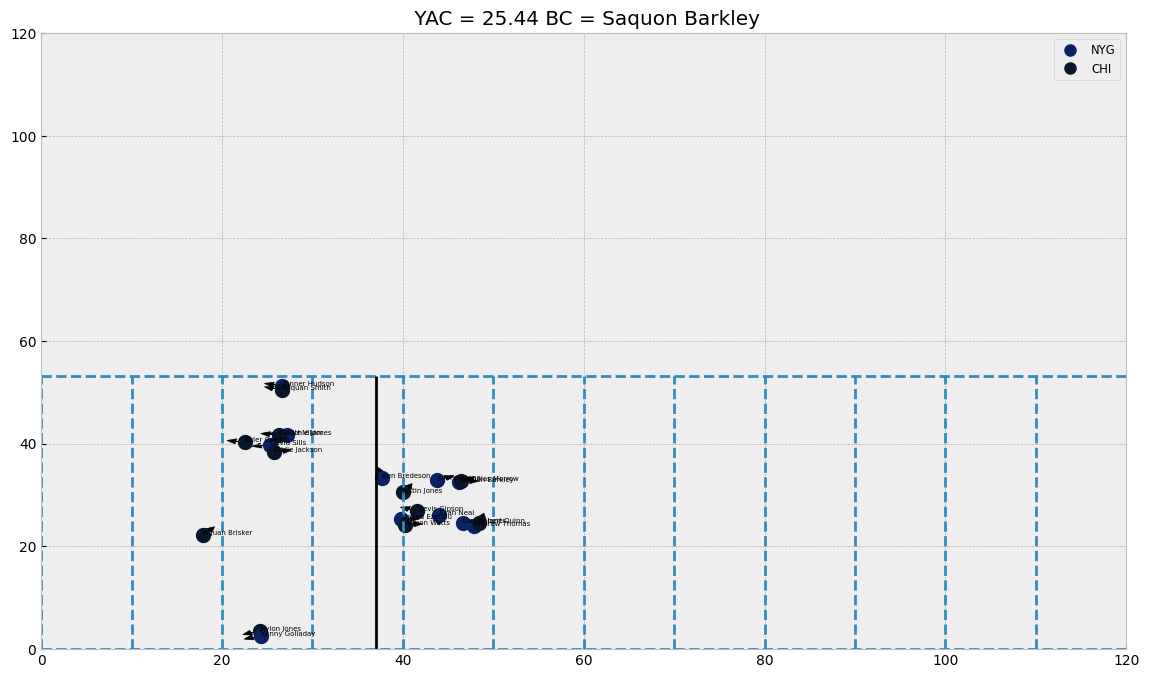

In [15]:
# Assuming nfl_colors is defined previously and feature_setup_df is your dataframe
colors = nfl_colors

# Set up the plot again with the requested adjustments
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the size to your preference

play_mask = (feature_setup_df['playId'] == play_id) & (feature_setup_df['gameId'] == game_id)

# Find the unique clubs involved in this specific play
unique_clubs = feature_setup_df.loc[play_mask, 'club'].unique()

# Initialize a dictionary to hold the legend handles to ensure unique labels
legend_handles = {}

# Plot player positions with colors based on 'club'
for _, row in feature_setup_df.loc[play_mask].iterrows():
    club_color = colors[row['club']]
    if row['club'] not in legend_handles:
        # Only add to legend if not already present
        legend_handles[row['club']] = plt.Line2D([0], [0], marker='o', color=club_color, markersize=8, linestyle='')

    ax.plot(row['x'], row['y'], 'o', markersize=10, color=club_color, label=row['club'])  # Larger dots
    # Annotate player name at a quarter of the default font size
    ax.text(row['x'], row['y'], row['displayName'], fontsize=plt.rcParams['font.size'] * 0.5)

    # Calculate the arrow direction based on the 'dir' column
    radians = np.radians((row['dir'] -90) * -1)
    dx = np.cos(radians)  # Change in x
    dy = np.sin(radians)  # Change in y

    # Draw the arrow from the player position in the direction they're facing
    ax.arrow(row['x'], row['y'], dx, dy, head_width=1, head_length=1, fc='k', ec='k')
    
    yac_title = np.round(row['yac'],2)
    ball_carrier = row['ballCarrierDisplayName']
    line_of_scrimmage = row['absoluteYardlineNumber']

# Set the limits of the plot
ax.set_xlim([0, 120])
ax.set_ylim([0, 120])
ax.hlines(y = [0,53.3],xmin = 0, xmax =120, linestyle = '--')
ax.vlines(x = line_of_scrimmage,ymin = 0, ymax =53.3, color = 'black')
ax.vlines(x = range(0,120,10),ymin = 0, ymax =53.3, linestyle = '--')
# Set title to include the two teams
if len(unique_clubs) == 2:
    title_teams = f"{unique_clubs[0]} vs {unique_clubs[1]}"
else:
    title_teams = "Multiple Teams"
ax.set_title(f' YAC = {yac_title} BC = {ball_carrier}')

# Create and add the legend for the clubs
handles, labels = [], []
for club in unique_clubs:
    handles.append(legend_handles[club])
    labels.append(club)
ax.legend(handles, labels, loc='upper right', fontsize='small')

# Show the plot
plt.show()

# Apply and Aggregate for Closest Player Features

In [16]:
group_by_list = ['gameId',
                 'playId',
                 'yardsToGo', 
                 'yac', 
                 'ballCarrierDisplayName', 
                 'offense_or_defense',
                 'down',
                 'quarter',
                 'gameClock',
                 'abs_score_diff',
                 'passLength',
                 'absoluteYardlineNumber',
                 'defendersInTheBox'
                ]


# apply_result_df = (feature_setup_df
#                 .groupby(group_by_list, as_index=False)
#                 .apply(lambda df: pd.Series({
#                     'players_downfield_within_1': calculate_players_downfield_within_radius(df, 1, 1),
#                     'players_downfield_within_3': calculate_players_downfield_within_radius(df, 3, 3),
#                     'players_downfield_within_5': calculate_players_downfield_within_radius(df, 5, 5),
#                     'players_downfield_within_7': calculate_players_downfield_within_radius(df, 7, 7),
#                     'players_downfield_within_10': calculate_players_downfield_within_radius(df, 10, 10),
#                     'players_downfield_within_15': calculate_players_downfield_within_radius(df, 15, 15),
#                     'players_upfield_within_1': calculate_players_upfield_within_radius(df, -1, 1),
#                     'players_upfield_within_3': calculate_players_upfield_within_radius(df, -3, 3),
#                     'players_upfield_within_5': calculate_players_upfield_within_radius(df, -5, 5),
#                     'players_upfield_within_7': calculate_players_upfield_within_radius(df, -7, 7),
#                     'players_upfield_within_10': calculate_players_upfield_within_radius(df, -10, 10),
#                     'players_upfield_within_15': calculate_players_upfield_within_radius(df, -15, 15),
#                 })))


apply_index_cols = ['gameId',
                 'playId',
                 'yardsToGo', 
                 'yac', 
                 'ballCarrierDisplayName', 
#                  'offense_or_defense',
                 'down',
                 'quarter',
                 'gameClock',
                 'abs_score_diff',
                 'passLength',
                 'absoluteYardlineNumber',
                 'defendersInTheBox'
                ]

apply_results_df = (feature_setup_df
                .groupby(group_by_list, as_index=False)
                .apply(lambda df: pd.Series({
                    'players_downfield_within_1': calculate_players_downfield_within_radius(df, 1, 1),
                    'players_downfield_within_2': calculate_players_downfield_within_radius(df, 2, 2),
                    'players_downfield_within_3': calculate_players_downfield_within_radius(df, 3, 3),
                    'players_downfield_within_5': calculate_players_downfield_within_radius(df, 5, 5),
                    'players_downfield_within_10': calculate_players_downfield_within_radius(df, 10, 10),
                    'players_upfield_within_1': calculate_players_upfield_within_radius(df, -1, 1),
                    'players_upfield_within_3': calculate_players_upfield_within_radius(df, -3, 3),
                    'players_upfield_within_5': calculate_players_upfield_within_radius(df, -5, 5),
                    'players_upfield_within_10': calculate_players_upfield_within_radius(df, -10, 10),
                    'players_behind_ball_carrier': calculate_players_upfield_within_radius(df, -120, 120)
                })))




apply_value_cols = ['players_downfield_within_1'
                    ,'players_downfield_within_2'
                    ,'players_downfield_within_3'
                    ,'players_downfield_within_5'
                    ,'players_downfield_within_10'
                    , 'players_upfield_within_1'
                    ,'players_upfield_within_3'
                    ,'players_upfield_within_5'
                    ,'players_upfield_within_10'
                    ,'players_behind_ball_carrier'
                   ]

apply_rename_cols = ['players_downfield_within_1_D'
                     ,'players_downfield_within_1_O'
                     ,'players_downfield_within_2_D'
                     ,'players_downfield_within_2_O'
                     ,'players_downfield_within_3_D'
                     ,'players_downfield_within_3_O'
                     ,'players_downfield_within_5_D'
                     ,'players_downfield_within_5_O'
                     ,'players_downfield_within_10_D'
                     ,'players_downfield_within_10_O'
                     ,'players_upfield_within_1_D'
                     ,'players_upfield_within_1_O'
                     ,'players_upfield_within_3_D'
                     ,'players_upfield_within_3_O'
                     ,'players_upfield_within_5_D'
                     ,'players_upfield_within_5_O'
                     ,'players_upfield_within_10_D'
                     ,'players_upfield_within_10_O'
                     ,'players_behind_ball_carrier_D'
                     ,'players_behind_ball_carrier_O'
                   ]

players_up_down_field_df = (apply_results_df.pivot(index = apply_index_cols
                      ,columns = ['offense_or_defense']
                      ,values = apply_value_cols)
                      .reset_index()
                      .pipe(lambda df: flatten_and_rename(df,apply_index_cols,apply_rename_cols))
)






agg_result = (feature_setup_df
              .groupby(['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName','offense_or_defense'], as_index=False)
              .agg({'distance_from_ball_carrier': [('within_radius_1', lambda x: calculate_players_within_radius(x, cutoff_distance=1)),
                                                   ('within_radius_2', lambda x: calculate_players_within_radius(x, cutoff_distance=2)),
                                                   ('within_radius_3', lambda x: calculate_players_within_radius(x, cutoff_distance=3)),
                                                   ('within_radius_5', lambda x: calculate_players_within_radius(x, cutoff_distance=5)),
                                                  ('within_radius_10', lambda x: calculate_players_within_radius(x, cutoff_distance=10))]
                   })

             )
                    
    
agg_result.columns =  ['_'.join(col).rstrip('_') for col in agg_result.columns.to_flat_index()]







value_cols = ['distance_from_ball_carrier_within_radius_1',
              'distance_from_ball_carrier_within_radius_2',
              'distance_from_ball_carrier_within_radius_3',
              'distance_from_ball_carrier_within_radius_5',
              'distance_from_ball_carrier_within_radius_10'
             ]

rename_cols = ['distance_from_ball_carrier_within_radius_1_D',
              'distance_from_ball_carrier_within_radius_1_O',
              'distance_from_ball_carrier_within_radius_2_D',
              'distance_from_ball_carrier_within_radius_2_O',
              'distance_from_ball_carrier_within_radius_3_D',
              'distance_from_ball_carrier_within_radius_3_O',
              'distance_from_ball_carrier_within_radius_5_D',
              'distance_from_ball_carrier_within_radius_5_O',
              'distance_from_ball_carrier_within_radius_10_D',
              'distance_from_ball_carrier_within_radius_10_O',
             ]
index_cols = ['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName']
player_within_radius_df = (agg_result.pivot(index= index_cols
                ,columns = ['offense_or_defense']
                 ,values = value_cols)
                .reset_index()
                .pipe(lambda df: flatten_and_rename(df,index_cols,rename_cols))
)

# Build Model Df and Set Predictor Cols

In [18]:
model_df = (
       players_up_down_field_df
      .merge(player_within_radius_df, on = ['gameId','playId','yac','ballCarrierDisplayName','yardsToGo'], how = 'inner')
      .merge(closest_defender_df, left_on = ['gameId','playId'],right_on=['gameId_closest_defender','playId_closest_defender'] , how = 'inner')
      .merge(closest_offensive_df, left_on = ['gameId','playId'],right_on=['gameId_closest_offense','playId_closest_offense'] , how = 'inner')
      .merge(behind_los_flag_df, on = ['gameId','playId'] , how = 'inner')
      .merge(ball_carrier_attr_df, on = ['gameId','playId'], how = 'inner')
      .merge(plays_df[~plays_df['passProbability'].isna()][['gameId','playId','passProbability']] , on = ['gameId','playId'], how = 'inner')
      .merge(plays_df[['gameId','playId','yards_from_td']] , on = ['gameId','playId'], how = 'inner')
      .assign(height_diff_closest_def = lambda df: df['ball_carrier_height'] - df['height_closest_defender'])
      .assign(weight_diff_closest_def = lambda df: df['ball_carrier_weight'] - df['weight_closest_defender'])
      .pipe(lambda df: df.merge(pd.get_dummies( df['down'].astype('category'),drop_first = False, prefix = 'down', dtype = int) , left_index=True, right_index=True))
      .pipe(lambda df: df.merge(pd.get_dummies( df['quarter'].astype('category'),drop_first = False, prefix = 'quarter', dtype = int) , left_index=True, right_index=True))
      .assign(
              # players_downfield_within_2_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_2_O'],df['players_downfield_within_1_O']),
              # players_downfield_within_3_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_3_O'],df['players_downfield_within_2_O']),
              # players_downfield_within_5_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_5_O'],df['players_downfield_within_3_O']),
              # players_downfield_within_10_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_10_O'],df['players_downfield_within_5_O']),
              # players_downfield_within_2_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_2_D'],df['players_downfield_within_1_D']),
              # players_downfield_within_3_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_3_D'],df['players_downfield_within_2_D']),
              # players_downfield_within_5_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_5_D'],df['players_downfield_within_3_D']),
              # players_downfield_within_10_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_10_D'],df['players_downfield_within_5_D']),
              # distance_from_ball_carrier_within_radius_2_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_2_D'],df['distance_from_ball_carrier_within_radius_1_D']),
              # distance_from_ball_carrier_within_radius_3_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_3_D'],df['distance_from_ball_carrier_within_radius_2_D']),
              # distance_from_ball_carrier_within_radius_5_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_5_D'],df['distance_from_ball_carrier_within_radius_3_D']),
              # distance_from_ball_carrier_within_radius_10_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_10_D'],df['distance_from_ball_carrier_within_radius_5_D']),
              # distance_from_ball_carrier_within_radius_2_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_2_O'],df['distance_from_ball_carrier_within_radius_1_O']),
              # distance_from_ball_carrier_within_radius_3_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_3_O'],df['distance_from_ball_carrier_within_radius_2_O']),
              # distance_from_ball_carrier_within_radius_5_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_5_O'],df['distance_from_ball_carrier_within_radius_3_O']),
              # distance_from_ball_carrier_within_radius_10_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_10_O'],df['distance_from_ball_carrier_within_radius_5_O']),
              
              blocker_defender_ratio_1 = lambda df: (df['players_downfield_within_1_O']/df['players_downfield_within_1_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_2 = lambda df: (df['players_downfield_within_2_O']/df['players_downfield_within_2_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_3 = lambda df: (df['players_downfield_within_3_O']/df['players_downfield_within_3_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_5 = lambda df: (df['players_downfield_within_5_O']/df['players_downfield_within_5_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_10 = lambda df: (df['players_downfield_within_10_O']/df['players_downfield_within_10_D']).replace([np.inf, -np.inf], 0).fillna(0) ,
              speed_times_cos_angle_approach = lambda df: df['cos_angle_of_approach_closest_defender'] * df['s_closest_defender'],
              distance_times_cos_angle_approach = lambda df: df['distance_from_ball_carrier_closest_defender'] * df['cos_angle_of_approach_closest_defender']
             )
      .drop(['down','quarter'],axis = 1)
)

pd.set_option('display.max_seq_items', None)



predictor_cols = ['players_behind_ball_carrier_D',
                  'distance_from_ball_carrier_closest_defender',
                  's_closest_defender',
                  'ball_carrier_s_closest_defender',
                  'cos_angle_of_approach_closest_defender',
                  # 'angle_of_approach_closest_defender',
                  # 'distance_from_ball_carrier_within_radius_1_D',
                  # 'distance_from_ball_carrier_within_radius_1_O',
                  # 'distance_from_ball_carrier_within_radius_2_D',
                  # 'distance_from_ball_carrier_within_radius_2_O',
                  # 'distance_from_ball_carrier_within_radius_3_D',
                  # 'distance_from_ball_carrier_within_radius_3_O',
                  # 'distance_from_ball_carrier_within_radius_5_D',
                  # 'distance_from_ball_carrier_within_radius_5_O',
                  # 'distance_from_ball_carrier_within_radius_10_D',
                  # 'distance_from_ball_carrier_within_radius_10_O',
                  # 'players_downfield_within_1_D',
                  # 'players_downfield_within_1_O', 
                  # 'players_downfield_within_2_D',
                  # 'players_downfield_within_2_O', 
                  'players_downfield_within_3_D',
                  'players_downfield_within_3_O', 
                  # 'players_downfield_within_5_D',
                  # 'players_downfield_within_5_O', 
                  'players_downfield_within_10_D',
                  'players_downfield_within_10_O', 
                  # 'players_upfield_within_1_D',
                  # 'players_upfield_within_3_D',
                  # 'players_upfield_within_3_O',
                  # 'players_upfield_within_5_D',
                  # 'players_upfield_within_5_O', 
                  # 'players_upfield_within_10_D',
                  'ball_carrier_speed_toward_sideline_closest_defender',
                  'ball_carrier_speed_toward_endzone_closest_defender',
                  'player_carrier_speed_toward_endzone_closest_defender',
                  'player_carrier_speed_toward_sideline_closest_defender',
                  'yardsToGo',
                  'defendersInTheBox',
                  # 'absoluteYardlineNumber',
                  'behind_los_flag',
                  'ball_carrier_distance_from_sideline_closest_defender',
                  'passLength_closest_offense',
                  'player_distance_from_sideline_closest_defender',
                  'yards_down_field_closest_defender',
                  'blocker_defender_ratio_1',
                  'blocker_defender_ratio_2',
                  'blocker_defender_ratio_3',
                  # 'blocker_defender_ratio_5',
                  # 'blocker_defender_ratio_10',
                  'yards_right_closest_defender',
                  'speed_times_cos_angle_approach',
                  'distance_times_cos_angle_approach',
                  # 'down_1',
                  'down_2',
                  'down_3',
                  'down_4',
                  # 'quarter_1',
                  'quarter_2',
                  'quarter_3',
                  'quarter_4',
                  'passProbability',
                  'yards_from_td'
                 ]

model_df.columns

Index(['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName',
       'gameClock', 'abs_score_diff', 'passLength', 'absoluteYardlineNumber',
       'defendersInTheBox', 'players_downfield_within_1_D',
       'players_downfield_within_1_O', 'players_downfield_within_2_D',
       'players_downfield_within_2_O', 'players_downfield_within_3_D',
       'players_downfield_within_3_O', 'players_downfield_within_5_D',
       'players_downfield_within_5_O', 'players_downfield_within_10_D',
       'players_downfield_within_10_O', 'players_upfield_within_1_D',
       'players_upfield_within_1_O', 'players_upfield_within_3_D',
       'players_upfield_within_3_O', 'players_upfield_within_5_D',
       'players_upfield_within_5_O', 'players_upfield_within_10_D',
       'players_upfield_within_10_O', 'players_behind_ball_carrier_D',
       'players_behind_ball_carrier_O',
       'distance_from_ball_carrier_within_radius_1_D',
       'distance_from_ball_carrier_within_radius_1_O',
       'dis

# Tweedie GLM

In [85]:
model_df[ model_df['players_behind_ball_carrier_D'] == 11][['gameId','playId','yac','distance_from_ball_carrier_closest_defender','ball_carrier_distance_from_sideline_closest_defender']]

,gameId,playId,yac,distance_from_ball_carrier_closest_defender,ball_carrier_distance_from_sideline_closest_defender
91,2022091102,2302,12.700001,2.315729,5.20
178,2022091105,1968,2.589996,1.542077,24.42
210,2022091106,1239,1.209999,0.246982,0.20
303,2022091109,2425,4.519999,2.191347,21.23
476,2022091500,741,1.560005,0.466476,5.51
1019,2022092503,2464,0.479996,1.128051,2.03
1025,2022092503,3154,1.580002,0.626259,26.02
1143,2022092508,786,0.579994,1.020000,-0.29
1144,2022092508,1262,1.129997,0.873670,3.28
1157,2022092508,2939,3.330002,0.784920,1.16


In [116]:
# Assuming model_df and predictor_cols are defined and model_df contains the 'yac' and 'gameId' columns
# predictor_cols = ['list', 'of', 'predictor', 'columns']

# Prepare the data
X = model_df[predictor_cols]
y = np.sqrt(model_df['yac'])
# X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

# Create a GLM model object with the Tweedie distribution using the training data
tweedie_model = sm.GLM(y_train, X_train, family=sm.families.Tweedie(var_power=1.21, link=sm.families.links.Log()))

# Fit the model with cluster-robust standard errors using the 'gameId' from the training data for clustering
tweedie_results = tweedie_model.fit()

# Print the summary of the model fit
print(tweedie_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    yac   No. Observations:                 2406
Model:                            GLM   Df Residuals:                     2372
Model Family:                 Tweedie   Df Model:                           33
Link Function:                    Log   Scale:                         0.54104
Method:                          IRLS   Log-Likelihood:                -3589.0
Date:                Mon, 27 Nov 2023   Deviance:                       1558.7
Time:                        02:59:13   Pearson chi2:                 1.28e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5253
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [106]:
# Assuming model_df is defined and contains the 'yac' and 'gameId' columns
# predictor_cols is a list of column names: ['col1', 'col2', 'col3', ...]

# # Create a formula string that includes all main effects and pairwise interactions
# formula = 'np.sqrt(yac) ~ ' + ' + '.join(predictor_cols) + ' + (' + ' + '.join(predictor_cols) + ')**2'

# # Split the data into training and testing sets
# train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

# # Create a GLM model object with the Tweedie distribution using the training data and the formula
# tweedie_model = smf.glm(formula=formula, data=train_data,
#                          family=sm.families.Tweedie(var_power=1.21, link=sm.families.links.Log()))

# # Fit the model with cluster-robust standard errors using the 'gameId' from the training data for clustering
# tweedie_results = tweedie_model.fit()

# # Print the summary of the model fit
# print(tweedie_results.summary())

In [95]:
# y_pred, y_test = tweedie_results.predict(test_data), np.sqrt(test_data['yac'])
# keep_index = y_pred.sort_values(ascending = False).iloc[10:].index
# y_pred = y_pred[keep_index]
# y_test = y_test[keep_index]

# plot_actual_vs_predicted(y_pred,y_test)

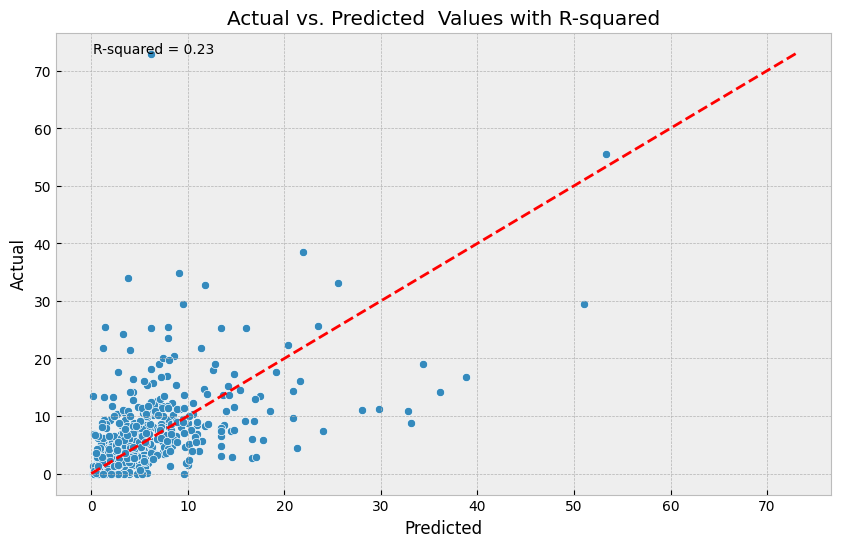

In [117]:
y_pred = tweedie_results.predict(X_test)
plot_actual_vs_predicted(y_pred**2,y_test**2)

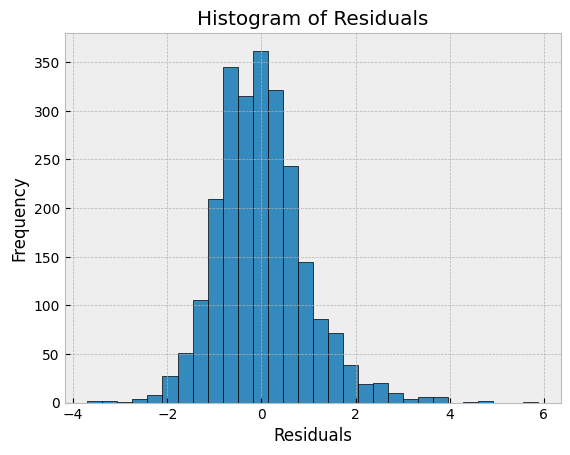

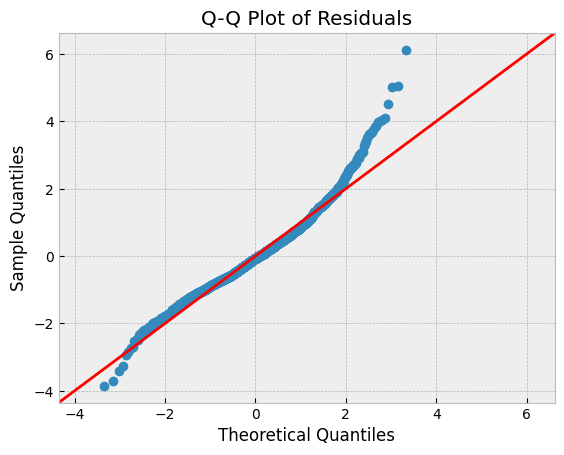

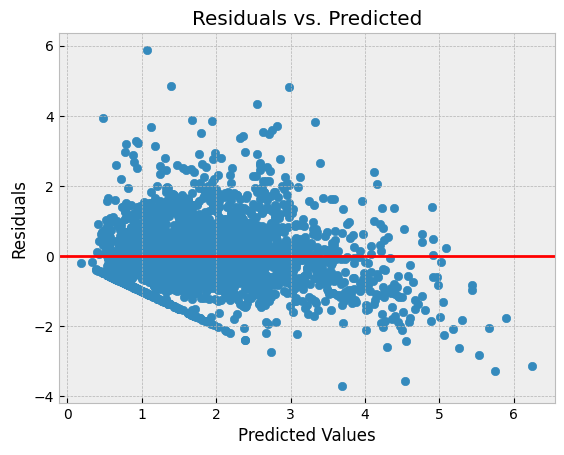

In [112]:
# Assuming 'tweedie_results' is the GLM model results object you have from fitting the model
residuals = tweedie_results.resid_response

# Plotting the residuals with a histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of the residuals to check for normality
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# You can also check for patterns in residuals with a scatter plot of predicted vs residuals
predicted_values = tweedie_results.fittedvalues
plt.scatter(predicted_values, residuals)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# XG Boost Approach

In [113]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 9, n_estimators = 500)

# Fit the regressor to the training set
xg_reg.fit(X_train_scaled ,y_train )

# Predict the labels of the test set
y_pred = xg_reg.predict(X_test_scaled)
y_pred_squared = y_pred**2

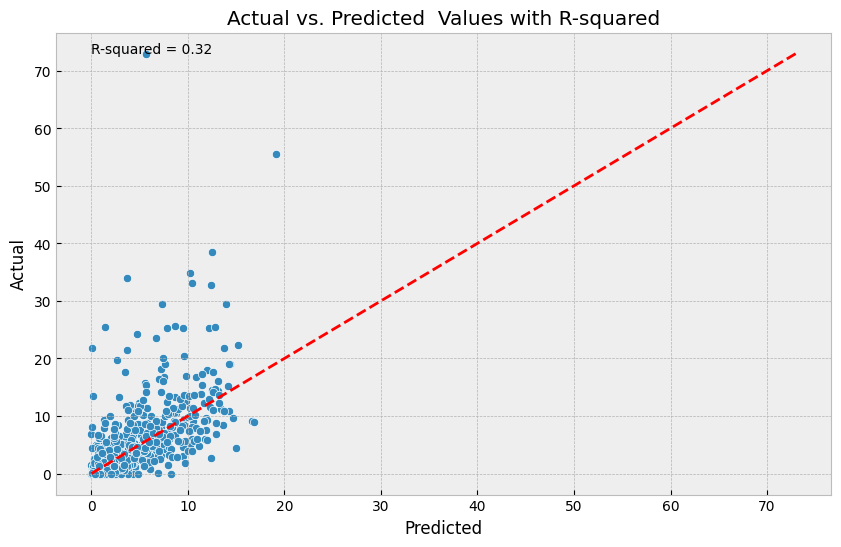

In [114]:
plot_actual_vs_predicted(y_pred**2,y_test**2 )

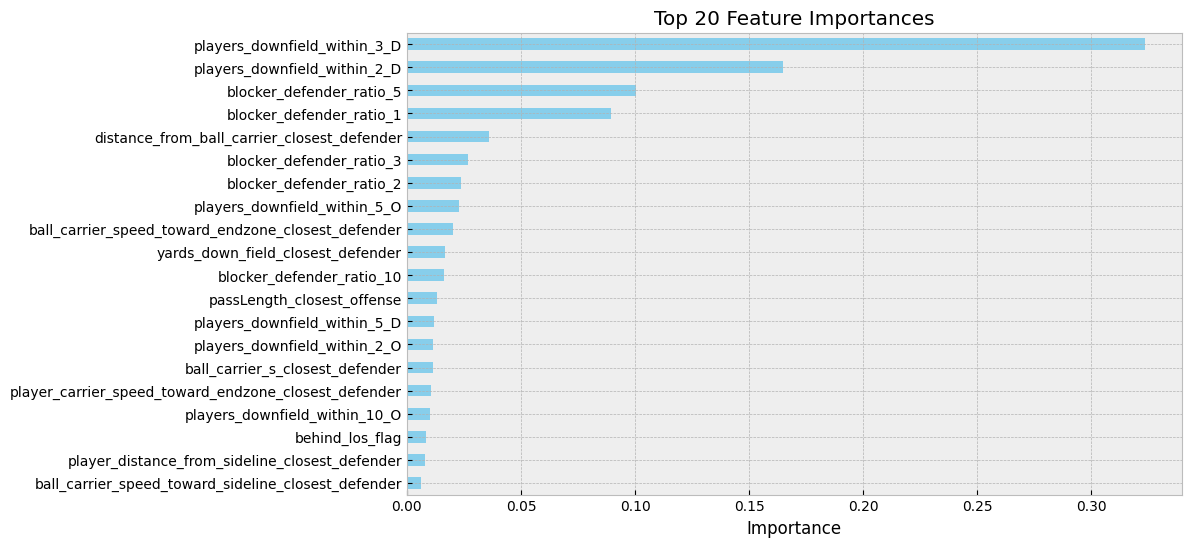

In [98]:
def plot_top_n_feature_importances(model, feature_names, n=10):
    # Get feature importances
    importances = model.feature_importances_
    
    # Convert to a Series for easy manipulation
    importance_series = pd.Series(importances, index=feature_names)
    
    # Sort the features by importance
    sorted_importance = importance_series.sort_values(ascending=False)
    
    # Select the top n features
    top_n_importance = sorted_importance.head(n)
    
    # Plot the top n feature importances
    plt.figure(figsize=(10, 6))
    top_n_importance.plot(kind='barh', color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Top {n} Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

plot_top_n_feature_importances(xg_reg, predictor_cols, 20)